# Mice Protein Expression (Introduction and Description)
Here, we examine 77 protein expression levels measured in the cerebral cortex of mice. The mice are split into many separate categories. First, the mice either possess a trisomy (resulting in down syndrome) or non-trisomic. Second, the mice are either stimulated to learn or note stimulated to learn. Third, the mice are either injected with saline or are injected with Memantine, which is used to treat Alzheimer's. Together, this results in 8 separate classes:
1. c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)
2. c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)
3. c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)
4. c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)
5. t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)
6. t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)
7. t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)
8. t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)

Thus, the question at hand is *can we cluster mice together using K-Means Clustering to effectively separate the 8 classes?*. To do this, we will use K-Means and permute the cluster indices to find the most accurate labels that correspond. This provides us a semi-parametric mean to classify mice protein expression levels. This will likely be a difficult task since there are a large number of predictors and relatively obscure classes. The notebook is organized as follows:
1. **Preamble**, where we load modules and create classes for loading, summarizing, and visualizing data.
2. **Preprocessing**, where we prepare data for modeling by removing missing values and describing the data.
3. **Feature Reduction**, where we perform dimensionality reduction on the dataset via PCA.
4. **Model Building**, where we build the K-Means model and prepare it for evaluation
5. **Model Evaluation**, where we predict the cluster and class of the test data on the K-Means model
6. **Conclusion**, where we discuss where the model performs well, fails, and delve further into its performance.

## Data Source
The dataset is availabel online at Kaggle and can be found [here](https://www.kaggle.com/datasets/ruslankl/mice-protein-expression)

## Github
If you are interested, this worked is posted on my GitHub. A link to that can be found [here](https://github.com/benjamin-ahlbrecht/mice-protein-expression).

## Preamble (Loading Modules and Creating a Data Class)
Here, we will load a number of necessary modules. `sklearn` will be used heavily for data reduction, model building, and model evaluation. `pandas` is used to read in and handle data as a `DataFrame()` object. `seaborn` and `matplotlib` provide impressive plotting capabilities, and `klib` provides some ease of access tools and visualizations for data-processing.

Our Data() class is used to store, split, and perform data reduction, while the DataTesting() class is used primarily to produce classification metrics and confusion matrix plots.

In [90]:
import numpy as np

# Data description, cleaning, and visualization
import klib
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Feature Reduction and preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Creation (Hierarchical)
from sklearn.cluster import KMeans

# Model evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from yellowbrick.cluster import SilhouetteVisualizer

# Data splitting
from sklearn.model_selection import train_test_split

from itertools import permutations

In [91]:
class Data():
    def __init__(self, data, target, train_proportion=0.75):
        """Class for loading, storing, splitting, and describing data.
        
        Parameters
        ----------
        data: Pandas Dataframe
            The full dataset prior to splitting
        target: String
            The column name of the target variable
        train_proportion: float, default=0.75
            The proportion of data to dedicate to a training set. The remainder will be dedicated to a testing set
        """
        data_x = data.drop(labels=target, axis=1)
        data_y = data[target]
        
        self.full = data
        self.train_proportion = train_proportion
        
        self.features = data_x.columns
        self.target = target
        
        # Standardize the features
        scaler = StandardScaler()
        data_x = scaler.fit_transform(data_x)
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            data_x, data_y, train_size=train_proportion, random_state=11235813
        )
    
    def __str__(self):
        nrows, ncols = self.full.shape
        return f"""\
Data({nrows} Observations x {ncols} Variables)
├── X Train:    {self.x_train.shape}
├── Y Train:    {self.y_train.shape}
├── X Test:     {self.x_test.shape}
├── Y Test:     {self.y_test.shape}
└── Train Size: {self.train_proportion}\
"""
    
    def pca(self, explained_variance_threshold=0.99):
        """Perform PCA on the training data to transform it into the principal
        components. This transformation is applied to the training data and only
        the most significant components are kept.
        
        This operation is done inplace, so the training and testing features
        will automatically be pruned.
        
        Parameters
        ----------
        explained_variance_threshold: float, default=0.98
            The cutoff value for [percentage of] explained variance. All
            remaining PCs will be discarded.
        """        
        # Perform PCA and transform our training data
        pca = PCA(n_components=explained_variance_threshold, svd_solver="full")
        x_train = pca.fit_transform(self.x_train)
        
        # Determine the feature names of the reduced data
        n_components = pca.components_.shape[0]
        
        # Get the index of the most important feature for each component
        feature_index = [np.abs(pca.components_[i]).argmax() for i in range(n_components)]
        
        # Extract the new feature names
        self.features = [self.features[feature_index[i]] for i in range(n_components)]
        
        # Remove the unselected features from the data
        self.x_train = self.x_train[:, feature_index]
        self.x_test = self.x_test[:, feature_index]
        
            


class DataTesting():
    def __init__(self, labels_pred, labels_truth, decoder: dict=None):
        """
        Class for testing our a fitted model given truth and predicted labels.
        
        Parameters
        ----------
        labels_pred: np.ndarray
            A numpy array containing the predicted labels from the model
        labels_truth: np.ndarray
            A numpy array containing the true labels from the model
        decoder: dict, default=None
            An optional dictionary used to decode the label values. Has the
            format decoder[encoded_label] -> label_name
        """
        assert isinstance(labels_pred, np.ndarray) and isinstance(labels_truth, np.ndarray), "Labels must be a NumPy array."
        assert labels_pred.shape == labels_truth.shape, "Labels must be of equal shape."
        self.pred = labels_pred
        self.truth = labels_truth
        self.decoder = {key: val for key, val in decoder.items()}
    
    def report(self):
        """
        Returns a report on evaluation metrics for the model such as
        specicifity and sensitivity.
        
        Returns
        -------
        report_df: pd.DataFrame
            The resulting model report in the form of a pandas dataframe
        """
        report = classification_report(
            self.truth,
            self.pred,
            output_dict=True
        )
                
        # Make a dataframe and rename the columnns
        report_df = pd.DataFrame.from_dict(report)
        report_df.rename(
            columns={str(key): val for key, val in self.decoder.items()},
            inplace=True
        )
                
        return report_df
    
    def confusion_matrix(self):
        """
        Computes the confusion matrix for the model.
        
        Returns
        -------
        confusion_matrix: pd.DataFrame
            The confusion matrix
        """
        n_features = len(np.unique(self.truth))
        matrix = np.zeros((n_features, n_features))
        for pred, truth in zip(self.pred, self.truth):
            matrix[pred, truth] += 1
        
        confusion_matrix = pd.DataFrame(matrix)
        confusion_matrix.rename(columns=self.decoder, inplace=True)
        confusion_matrix.rename(index=self.decoder, inplace=True)
        
        return confusion_matrix

    def confusion_matrix_plot(self, confusion_matrix=None):
        """
        Returns a figure corresponding to the model's confusion matrix.
        
        Arguments
        ---------
        confusion_matrix: None or pd.DataFrame, default=None
            The confusion matrix to plot against. If None, it will generate
            one from the class attributes
        """
        if confusion_matrix is None:
            confusion_matrix = self.confusion_matrix()
            
        fig, ax = plt.subplots(figsize=(11, 10), tight_layout=True)        
        sns.heatmap(
            data=confusion_matrix,
            robust=True,
            cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True),
            annot=True,
            fmt=".100g",
            linewidth=0.5,
            ax=ax,
            square=True
        )
        
        ax.set_xlabel("True Label")
        ax.set_ylabel("Predicted Label")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        return fig, ax


## Preprocessing (Loading Data and Handling Missing Values)
Here, we load the data in from its relative path and investigate for missing values. We will also remove some unecessary or redundant dimensions. 

GridSpec(6, 6)

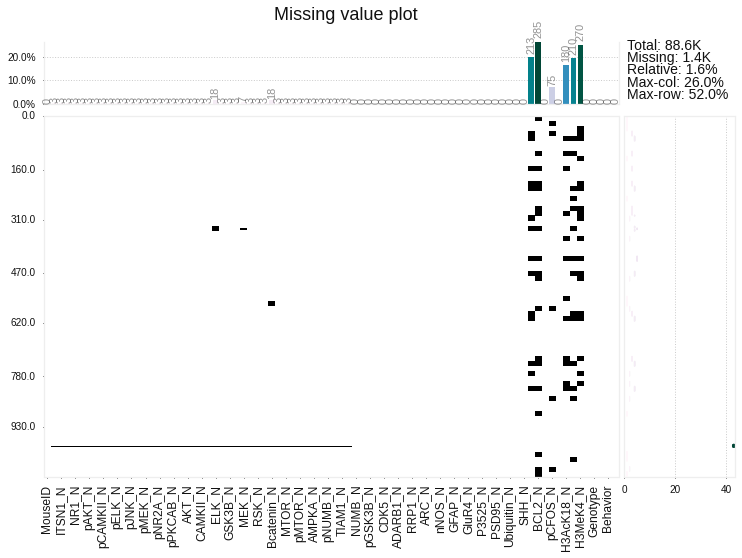

In [92]:
# Specify the location of our data
fname = r"../Data/data_cortex_nuclear.csv"

# Load the data as a DataFrame
df = pd.read_csv(fname)

# Examine the data for missing values
klib.missingval_plot(df, figsize=(12, 8))

In [93]:
# Find all the NA's in the dataframe
df_nas = df.isna().sum().sort_values(ascending=False)
df_nas = df_nas[df_nas > 0]
print(df_nas.to_string())

# Remove the genotype, treatment, and behavior columns (All in Class)
df.drop(labels=["Genotype", "Treatment", "Behavior"], axis=1, inplace=True)

# We can also drop MouseID because they are all unique
if len(df["MouseID"]) == len(df):
    df.drop(labels="MouseID", axis=1, inplace=True)

# We will first drop data from columns with more than 50 NAs
df.dropna(axis=1, thresh=len(df) - 50, inplace=True)

# Drop the remaining rows with NAs present
df.dropna(axis=0, how="any", inplace=True)

print(f"Remaining NA Values: {np.sum(df.isna().to_numpy())}")

BCL2_N        285
H3MeK4_N      270
BAD_N         213
EGR1_N        210
H3AcK18_N     180
pCFOS_N        75
ELK_N          18
Bcatenin_N     18
MEK_N           7
P38_N           3
JNK_N           3
TRKA_N          3
RSK_N           3
SOD1_N          3
MTOR_N          3
RAPTOR_N        3
pMTOR_N         3
DSCR1_N         3
AMPKA_N         3
GSK3B_N         3
pNUMB_N         3
DYRK1A_N        3
TIAM1_N         3
pP70S6_N        3
NR2B_N          3
APP_N           3
ERK_N           3
PKCA_N          3
NR1_N           3
NR2A_N          3
pAKT_N          3
pBRAF_N         3
CREB_N          3
pCAMKII_N       3
pCREB_N         3
pELK_N          3
BDNF_N          3
pJNK_N          3
pERK_N          3
pMEK_N          3
pNR1_N          3
pNR2A_N         3
pNR2B_N         3
pPKCAB_N        3
pRSK_N          3
AKT_N           3
BRAF_N          3
CAMKII_N        3
ITSN1_N         3
Remaining NA Values: 0


## Preprocessing (Describing and Visualizing Data)
We should also look at a correlation matrix to see if some features co-vary. These will likely be removed in PCA as there provide little additional information in the data. We can also examine density estimates to make sure there are no data inconsistencies.

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


/home/benjamin/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<AxesSubplot:xlabel='CaNA_N', ylabel='Density'>

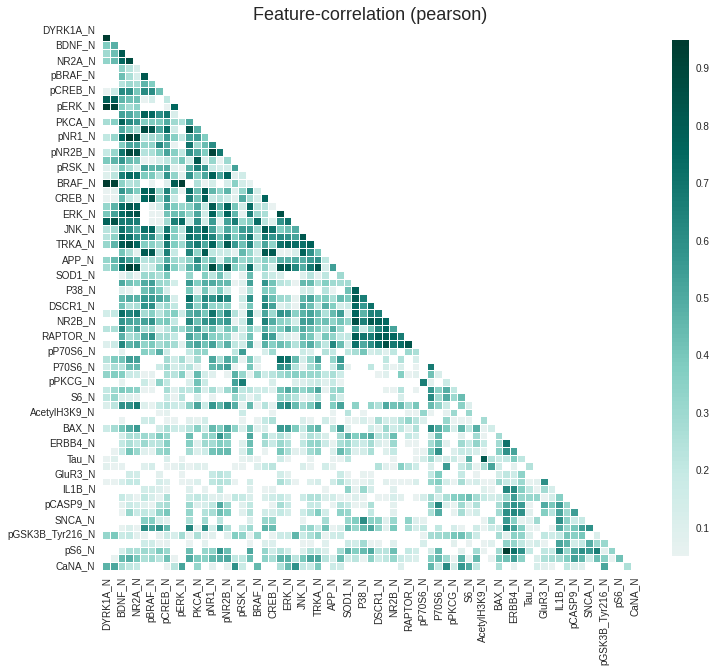

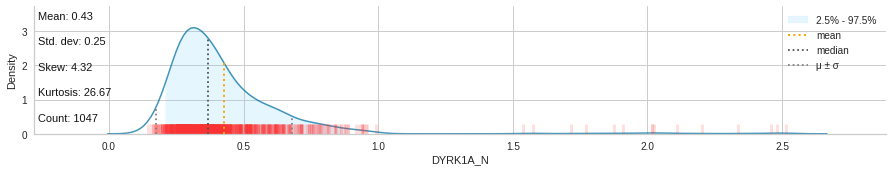

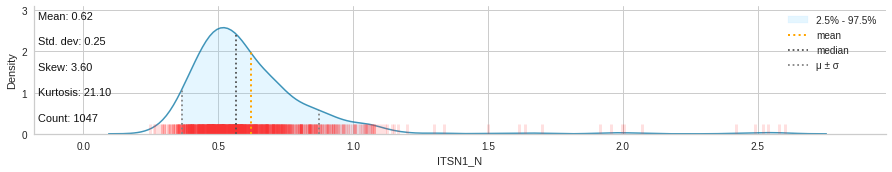

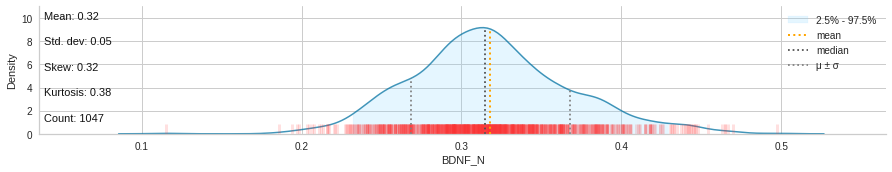

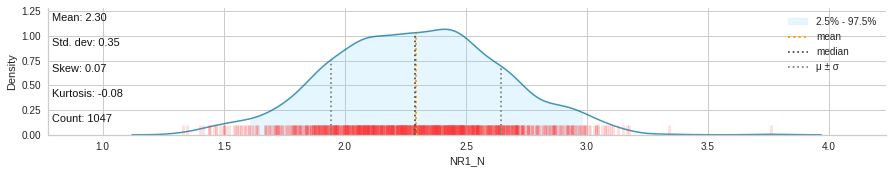

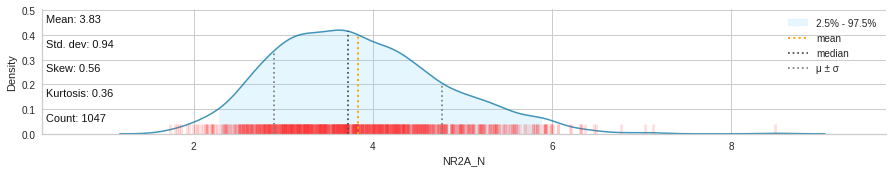

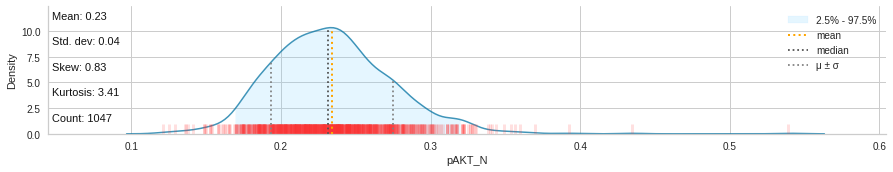

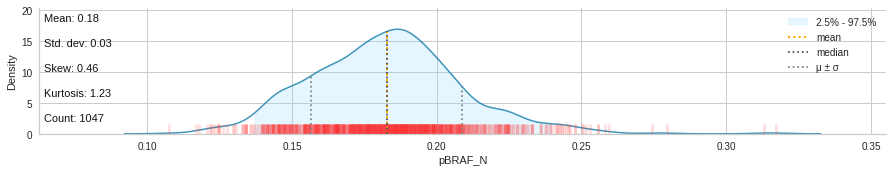

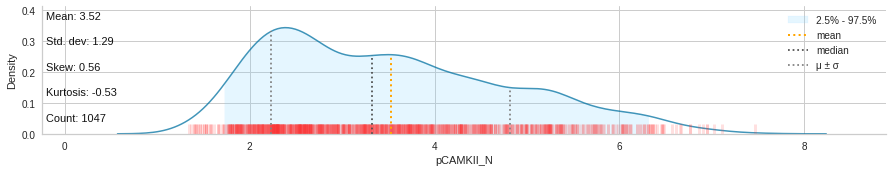

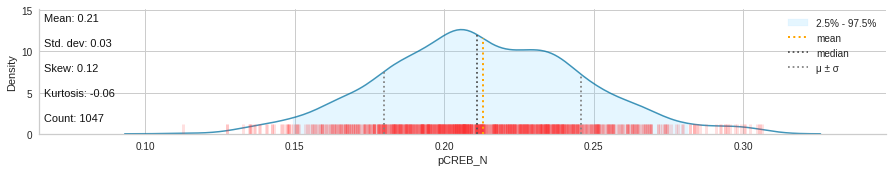

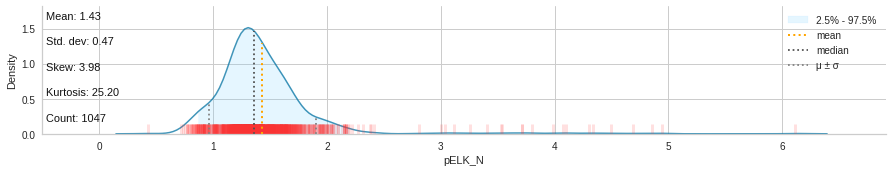

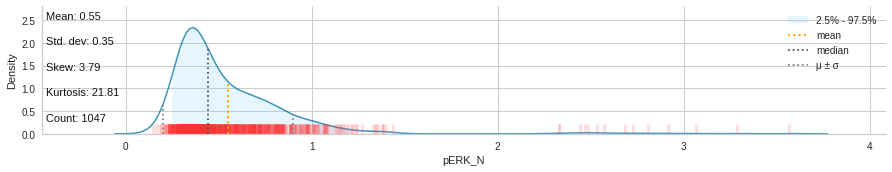

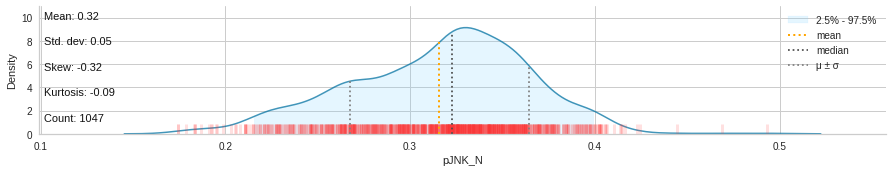

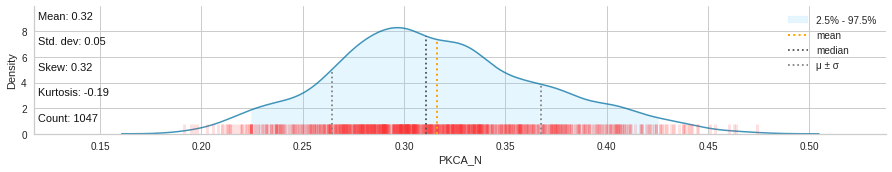

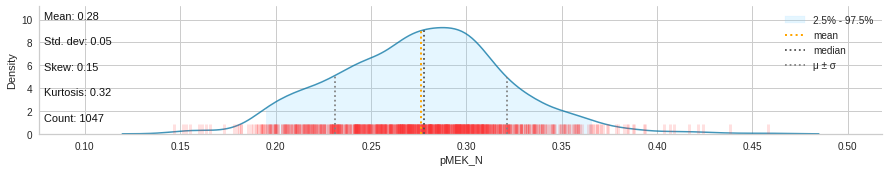

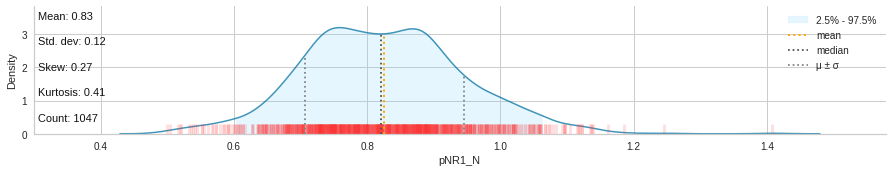

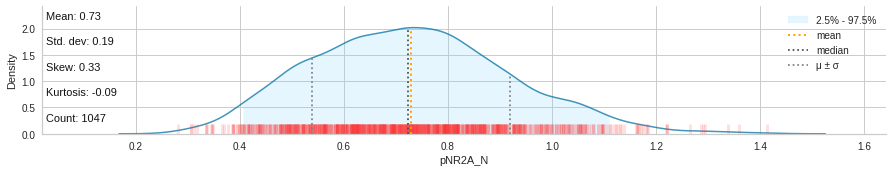

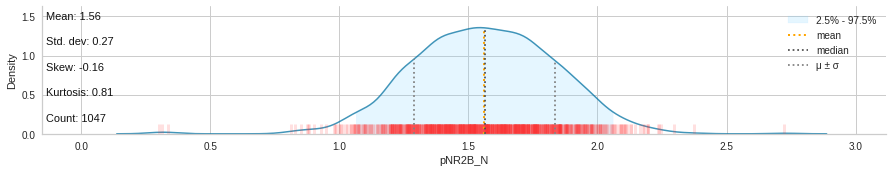

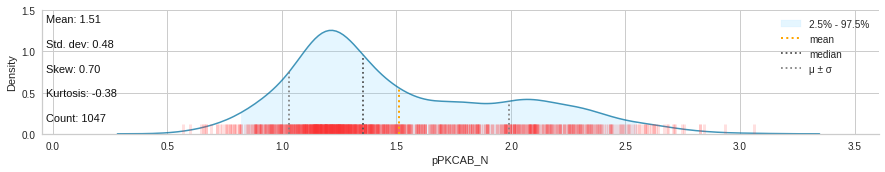

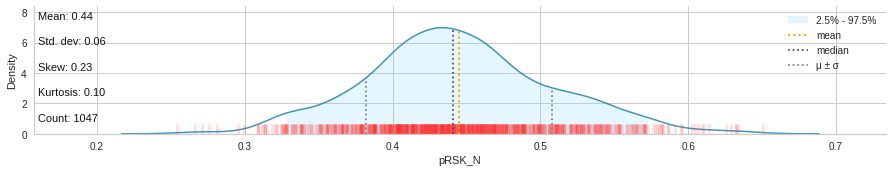

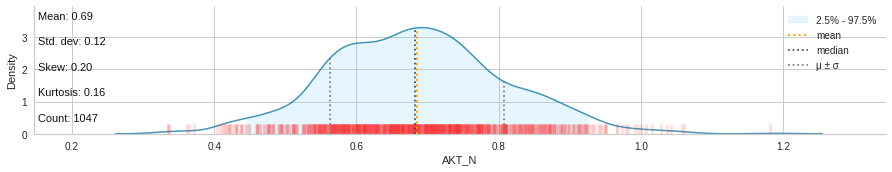

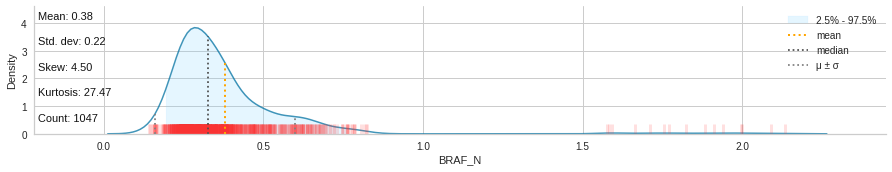

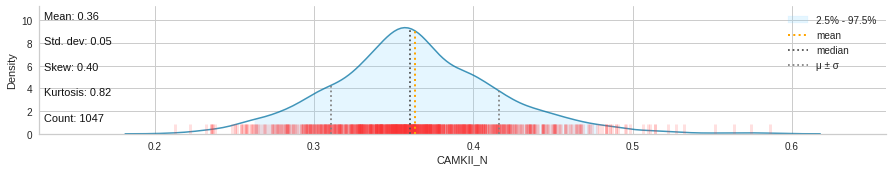

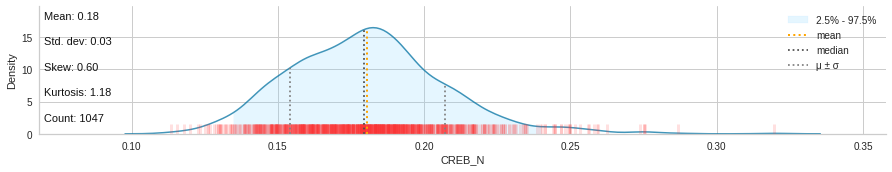

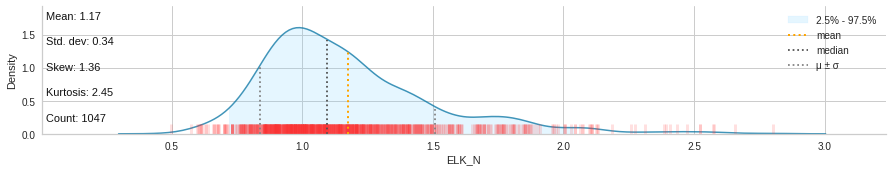

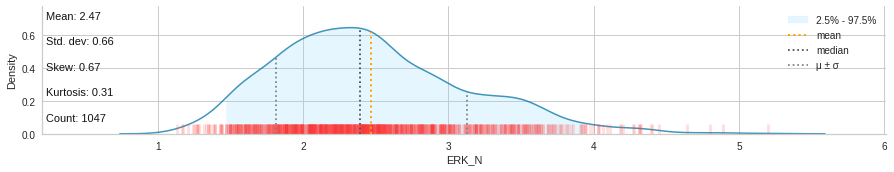

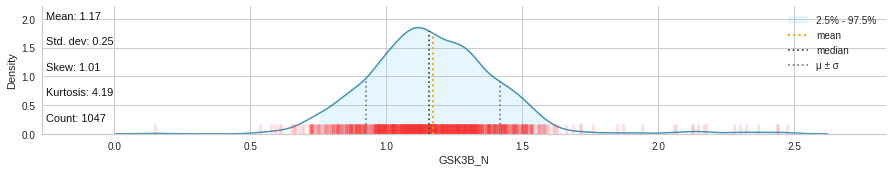

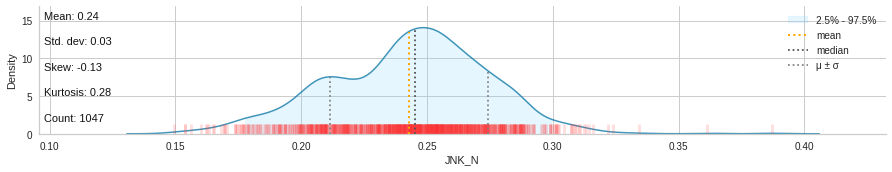

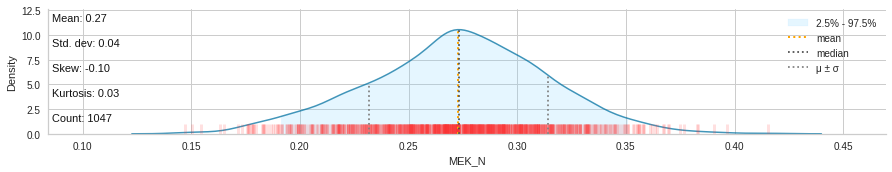

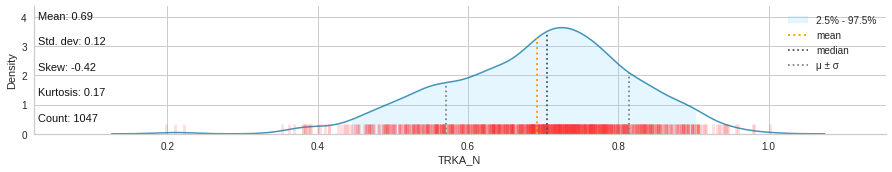

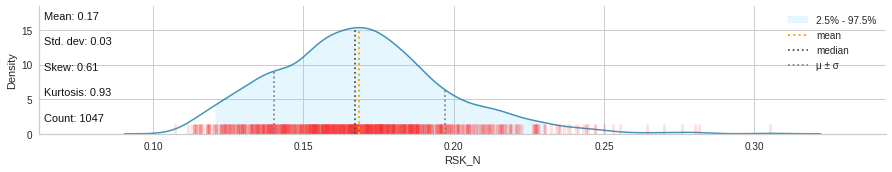

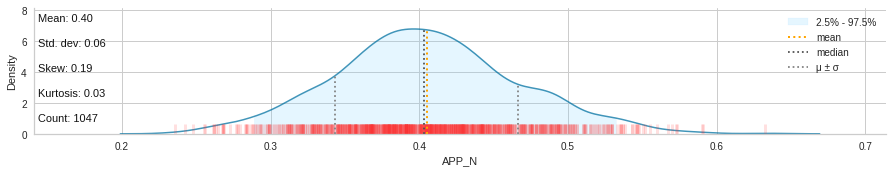

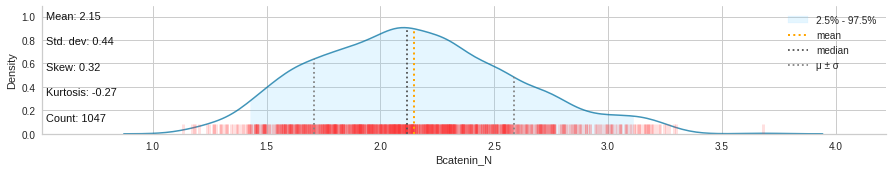

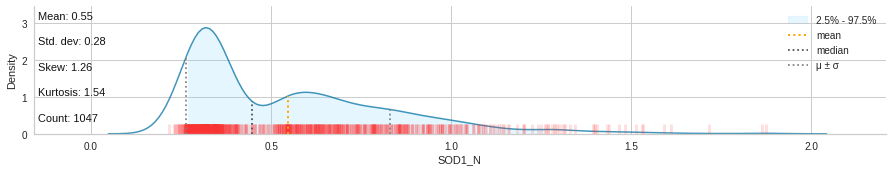

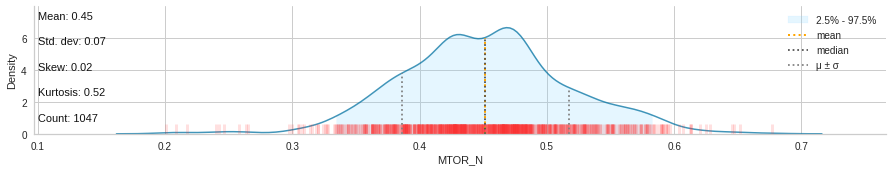

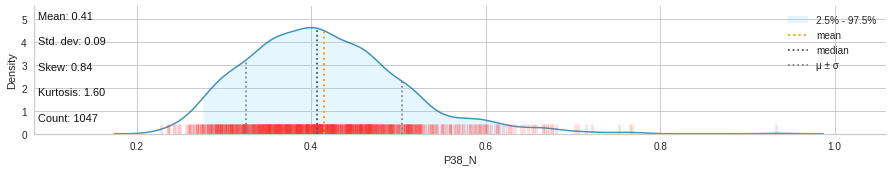

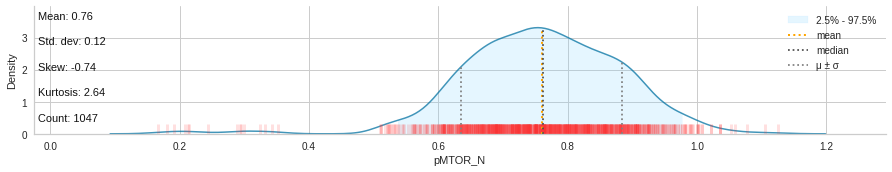

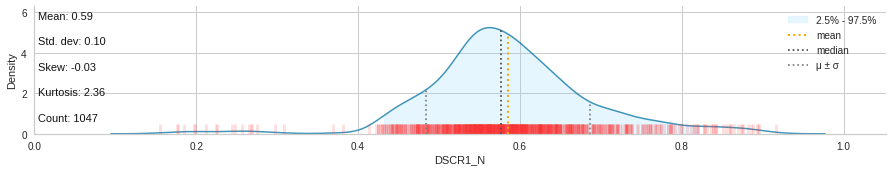

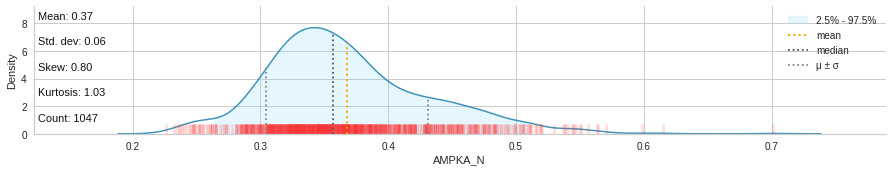

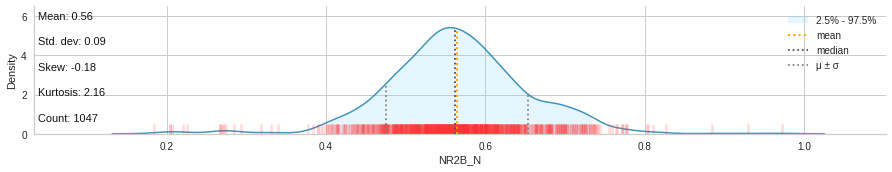

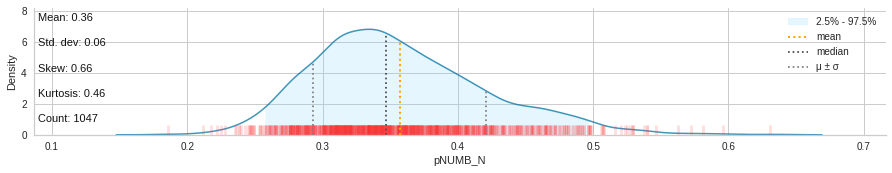

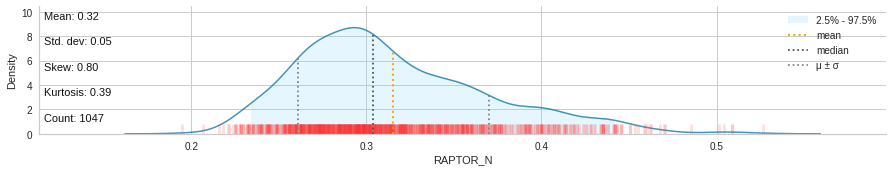

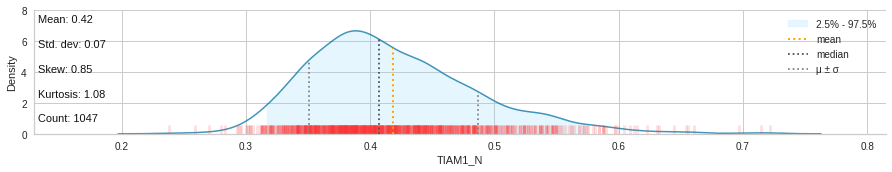

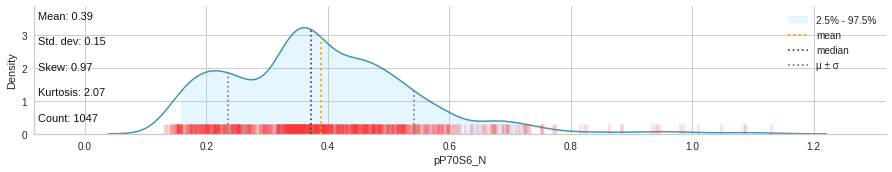

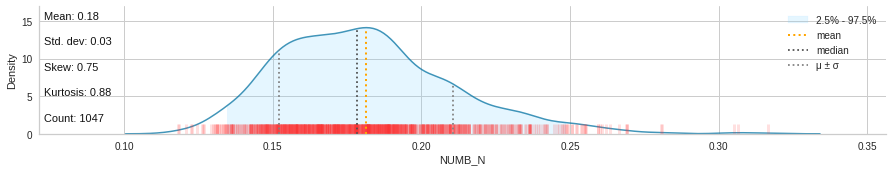

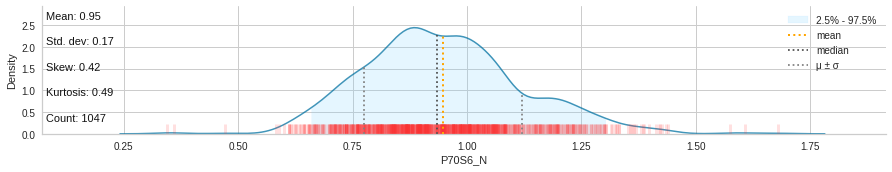

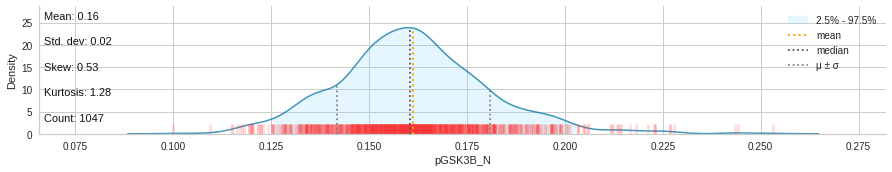

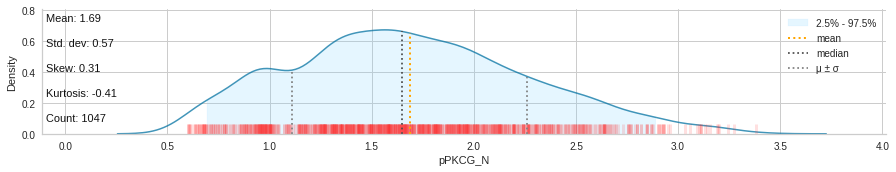

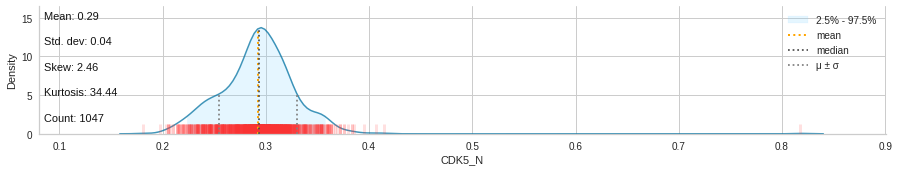

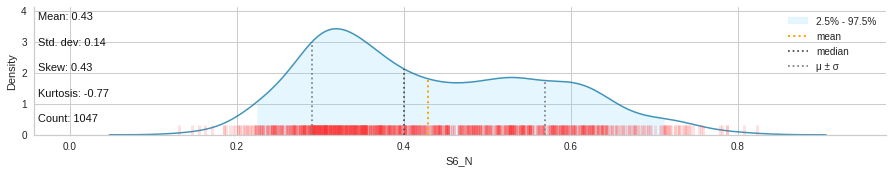

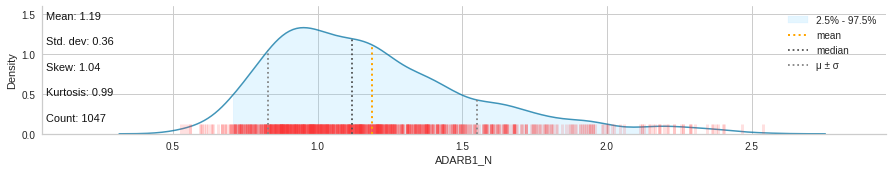

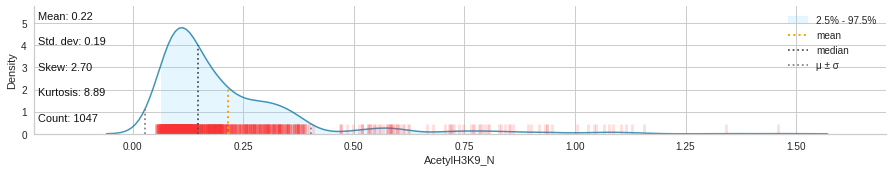

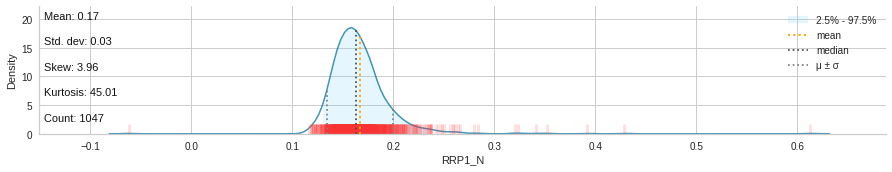

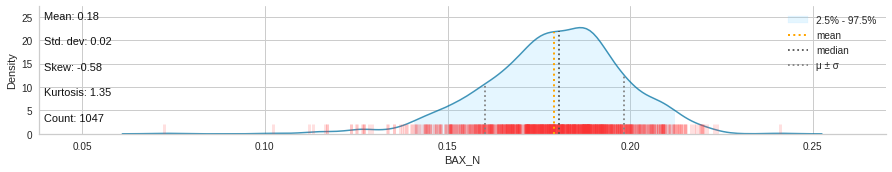

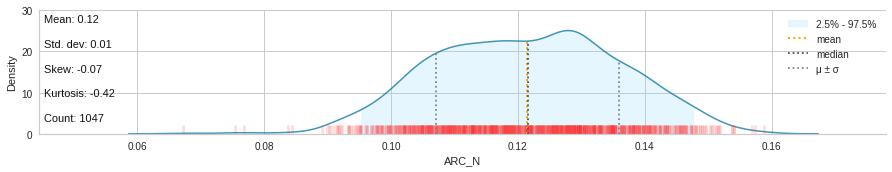

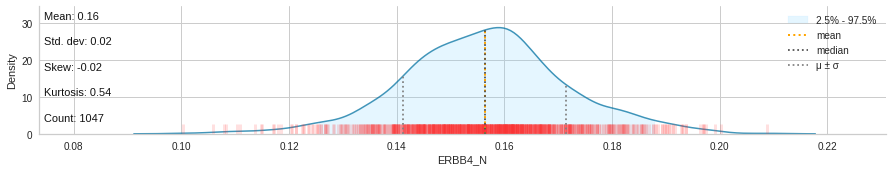

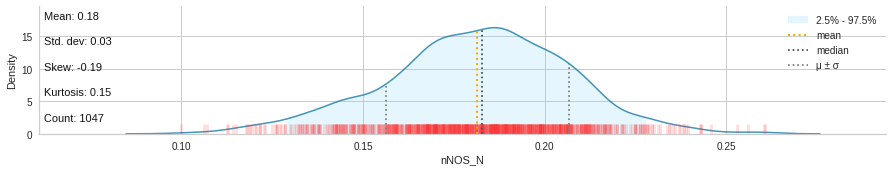

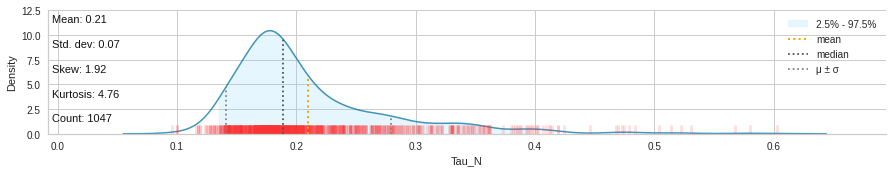

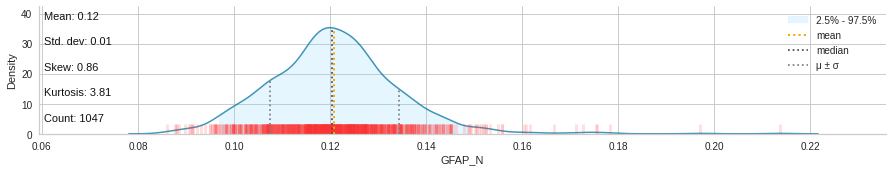

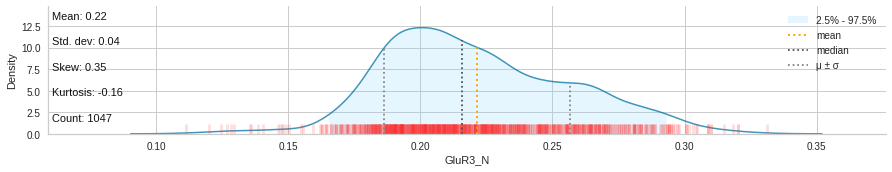

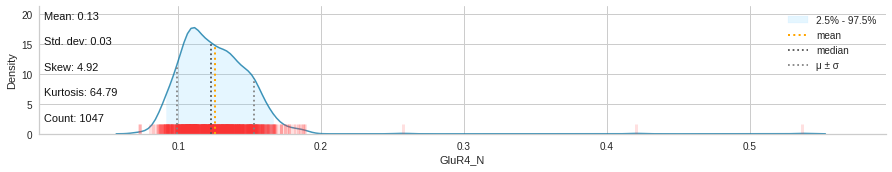

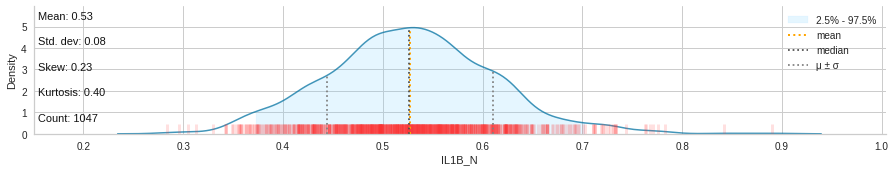

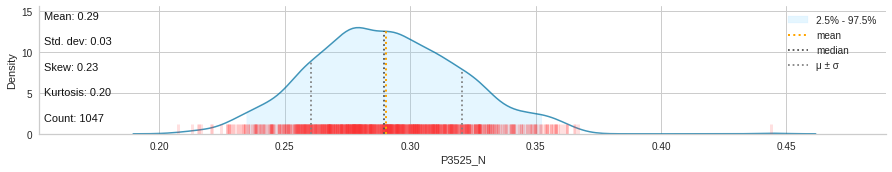

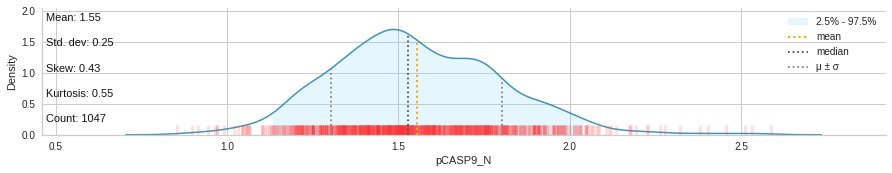

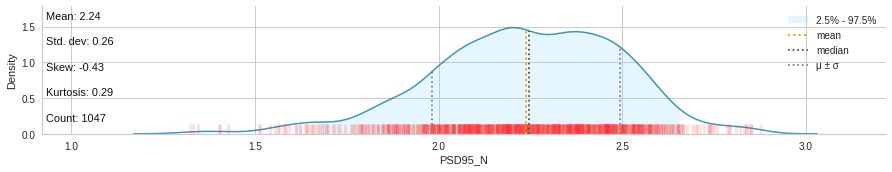

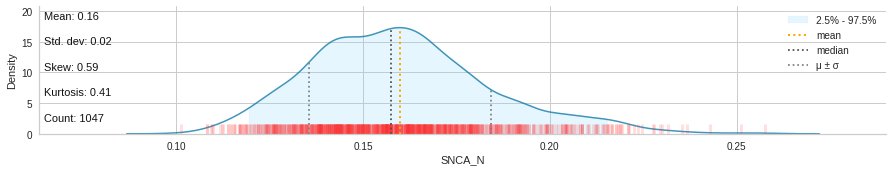

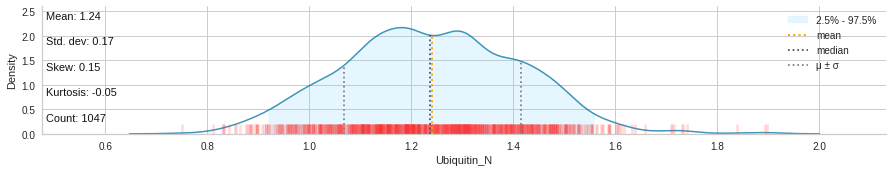

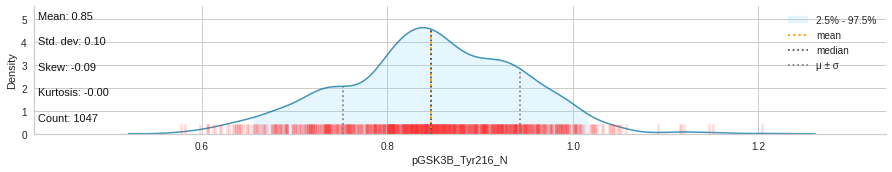

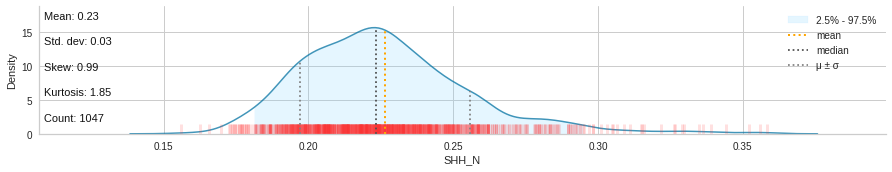

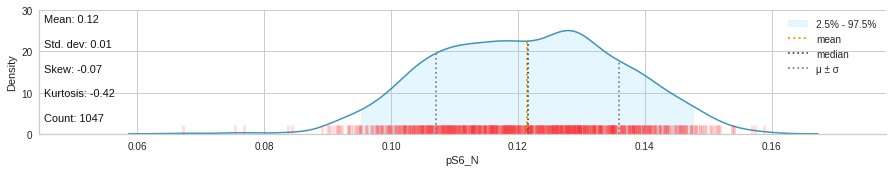

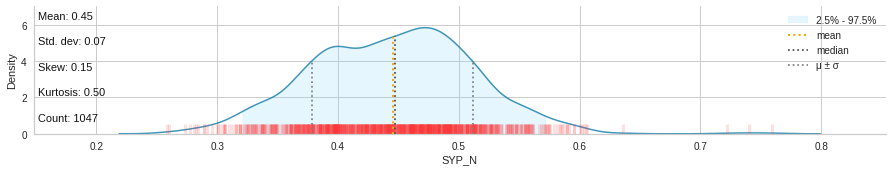

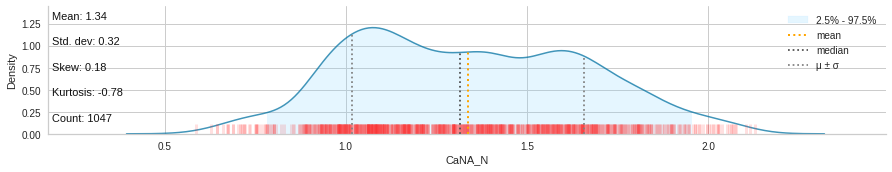

In [104]:
klib.corr_plot(df, split="pos", method="pearson", annot=False)
klib.dist_plot(df, showall=True)

## Preprocessing (Data Splitting)
We initialize our Data() class, which will split our data into training and testing sets. Prior to this, it will also standardize the entire dataset.

In [95]:
data = Data(df, "class", train_proportion=0.70)
print(data)

Data(1047 Observations x 72 Variables)
├── X Train:    (732, 71)
├── Y Train:    (732,)
├── X Test:     (315, 71)
├── Y Test:     (315,)
└── Train Size: 0.7


## Feature Reduction (Dimensionality Reduction via PCA)
A high dimensional space makes clustering difficult in many algorithms. To remedy this, we perform PCA to work in a *much* lower dimensional space. This should increase the efficiency and performance of our model.

In [96]:
data.pca(explained_variance_threshold=0.8)
print(data)
print(data.features)

Data(1047 Observations x 72 Variables)
├── X Train:    (732, 9)
├── Y Train:    (732,)
├── X Test:     (315, 9)
├── Y Test:     (315,)
└── Train Size: 0.7
['MEK_N', 'SNCA_N', 'P70S6_N', 'pPKCG_N', 'GFAP_N', 'pPKCG_N', 'Tau_N', 'pGSK3B_Tyr216_N', 'GluR4_N']


## Model Building
Here, we will initialize our K-Means model. Additionally, we create a function for comparing cluster indices to the true training labels. We will assign clusters to the labels that provide the highest accuracy and maintain the same mapping when we make predictions from the testing data.

In [97]:
def link_labels(cluster_pred, label_truth, labels=None):
    """Links cluster predictions to labels based on accuracy.
    
    Parameters
    ----------
    cluster_pred: np.ndarray
        1D array of cluster index predictions
    label_truth: Iterable
        1D iterable of the true labels
    labels: None or iterable of strings
        The potential labels. If None, potential labels are inferred directly
        from label_truth
    
    Returns
    -------
    best_mapping: dictionary
        The best mapping between a label and a cluster index
    """
    if labels is None:
        labels = pd.unique(label_truth)
    
    # Maintain a best f1 and mapping
    best_acc = 0
    best_mapping = None
    
    n = len(cluster_pred)
    
    # Iterate through each potential permutation
    for perm in permutations(range(len(labels))):
        # Generate a mapping between cluster index and label
        mapping = {labels[a]: i for i, a in enumerate(perm)}
        
        # Apply the mapping the the labeled data
        cluster_true = np.array([mapping[label] for label in label_truth])
        
        # Compute the accuracy
        acc = np.sum(cluster_pred == cluster_true) / n
        
        if acc > best_acc:
            best_acc = acc
            best_mapping = mapping
            
    return best_mapping

In [98]:
model = KMeans(n_clusters=8, n_init=200, max_iter=2000)

## Model Training and Training Performance

In [99]:
# Fit the model to the training data
model.fit(data.x_train)

# Extract the cluster indices
clusters_fitted_x = model.labels_



### Classification

{'t-SC-m': 0,
 't-SC-s': 1,
 't-CS-s': 2,
 'c-SC-s': 3,
 'c-SC-m': 4,
 'c-CS-m': 5,
 't-CS-m': 6,
 'c-CS-s': 7}

,t-SC-m,t-SC-s,t-CS-s,c-SC-s,c-SC-m,c-CS-m,t-CS-m,c-CS-s,accuracy,macro avg,weighted avg
precision,0.709677,0.600000,0.171171,0.182796,0.350427,0.206522,0.306452,0.0,0.321038,0.315881,0.329073
recall,0.226804,0.652174,0.275362,0.200000,0.376147,0.190000,0.570000,0.0,0.321038,0.311311,0.321038
f1-score,0.343750,0.625000,0.211111,0.191011,0.362832,0.197917,0.398601,0.0,0.321038,0.291278,0.301703
support,97.000000,92.000000,69.000000,85.000000,109.000000,100.000000,100.000000,80.0,0.321038,732.000000,732.000000


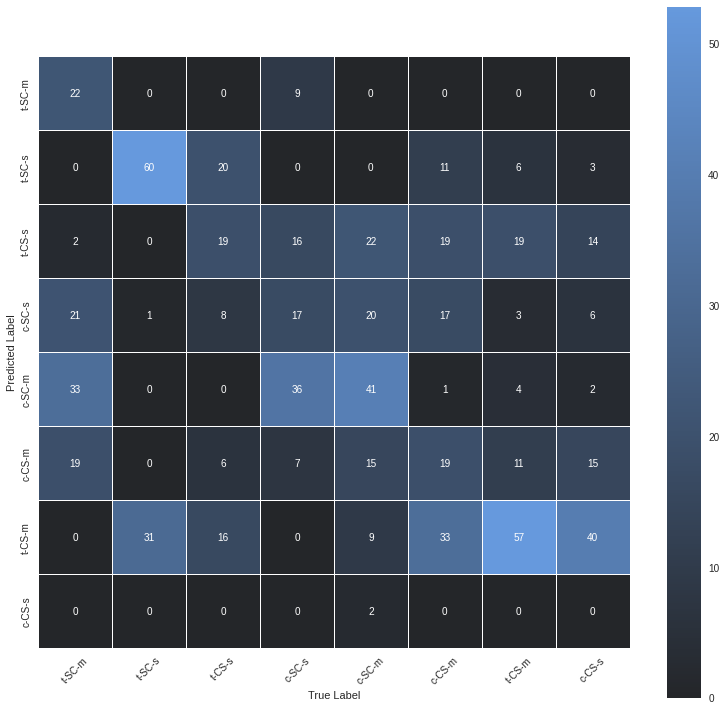

In [100]:
# Create the best mapping between labels and clusters
mapping = link_labels(clusters_fitted_x, data.y_train)
mapping_r = {v:k for k, v in mapping.items()}
display(mapping)

# Convert the labels to cluster indices
clusters_train_y = np.array([mapping[label] for label in data.y_train])

# Create a confusion matrix
tester = DataTesting(
    labels_pred=clusters_fitted_x,
    labels_truth=clusters_train_y,
    decoder=mapping_r
)

tester.confusion_matrix_plot()
display(tester.report())

### Cluster Metrics

In [101]:
# Count the number of elements in each cluster
cluster, count = np.unique(clusters_fitted_x, return_counts=True)

display(pd.DataFrame(count, columns=["Frequency"], index=[f"Cluster {a}" for a in cluster]))
print(f"KMeans Inertia: {model.inertia_}")

,Frequency
Cluster 0,31
Cluster 1,100
Cluster 2,111
Cluster 3,93
Cluster 4,117
Cluster 5,92
Cluster 6,186
Cluster 7,2


KMeans Inertia: 3252.990848746761


## Model Evaluation and Results
Now, we will predict from the testing data and make a confusion matrix and classification report similar to the training data.

In [102]:
# Predict clusters
pred = model.predict(data.x_test)

### Classification

/home/benjamin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/benjamin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/benjamin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,t-SC-m,t-SC-s,t-CS-s,c-SC-s,c-SC-m,c-CS-m,t-CS-m,c-CS-s,accuracy,macro avg,weighted avg
precision,0.500000,0.490566,0.195652,0.179487,0.367347,0.181818,0.222222,0.0,0.285714,0.267137,0.266280
recall,0.157895,0.650000,0.250000,0.200000,0.439024,0.160000,0.457143,0.0,0.285714,0.289258,0.285714
f1-score,0.240000,0.559140,0.219512,0.189189,0.400000,0.170213,0.299065,0.0,0.285714,0.259640,0.258373
support,38.000000,40.000000,36.000000,35.000000,41.000000,50.000000,35.000000,40.0,0.285714,315.000000,315.000000


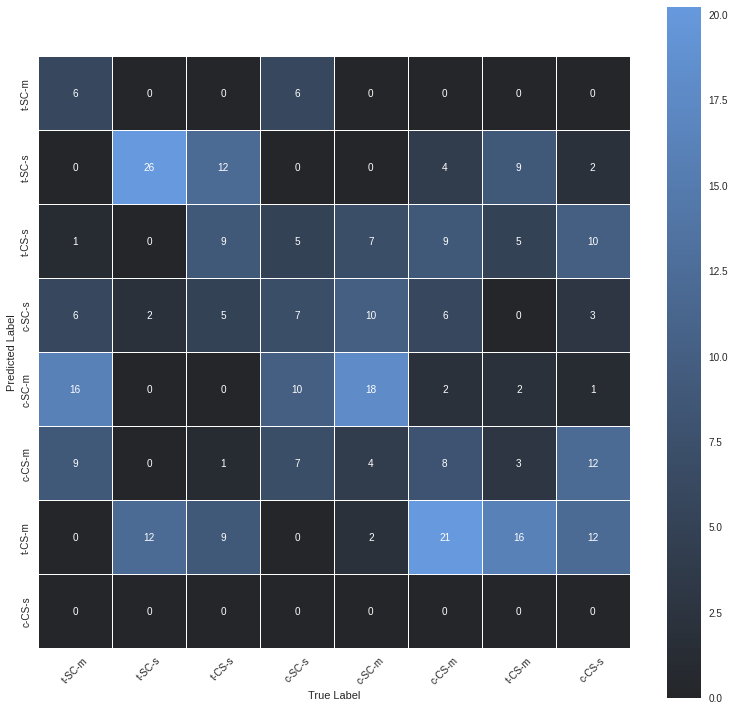

In [103]:
# Convert labels to cluster indices
true = np.array([mapping[label] for label in data.y_test])

# Create a confusion matrix
tester = DataTesting(
    labels_pred=pred,
    labels_truth=true,
    decoder=mapping_r
)

tester.confusion_matrix_plot()
display(tester.report())

## Conclusion
Overall, it may initially be difficult to say that the model performed well. With an overall accuracy of `29%`, an average precision of `27%`, an average recall of `29%`, and an average F1 score of `26%`. This model performs approximately twice as well as a random model. With 8 class, we expect a random class to have an accuracy of `12.5%`. With a total of 71 features, there are many co-varying features. This means that, while we had a lot of information, much of the information was redundant and did not have predictive power. Additionally, with 1047 total observations, it may be difficult to build a powerful model. A purely supervised approach would likely work much better since the 8 classes may be too similar to confidently distinguish.